In [ ]:
!pip install transformers
!pip install datasets[aws]
!pip install jiwer

import os
import torch
import soundfile as sf
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, Wav2Vec2Processor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
# load the pretrained model from huggingface
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# load the datasets from LibriSpeech
librispeech_dataset = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr_dummy downloaded and prepared to /root/.cache/huggingface/datasets/patrickvonplaten___librispeech_asr_dummy/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc. Subsequent calls will reuse this data.


Expected transcription:  MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL

Actual transcription:  MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL
-----------------------------------------------------------------------------------------
Expected transcription:  NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER

Actual transcription:  NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER
-----------------------------------------------------------------------------------------
Expected transcription:  HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMANUS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND

Actual transcription:  HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND
-----------------

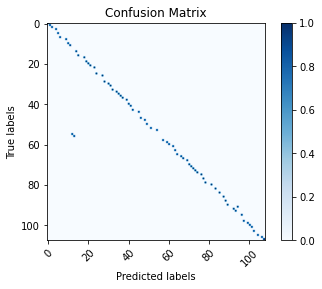

This model has successfully re-tested using the LibriSpeech datasets
CER: 1.67%
WER: 5.30%


In [ ]:
from jiwer import wer
from jiwer import cer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Set the desired audio length
desired_length = 16000  # 1 second at 16kHz

# Create lists to hold the expected truth transcriptions and predicted transcriptions
expected_transcriptions = []
predicted_transcriptions = []

# Get true and predicted labels
y_true = [sample["text"] for sample in librispeech_dataset]
y_pred = []

for eachAudio in librispeech_dataset:
    # Load the audio data and sample rate
    audio_input, sample_rate = sf.read(eachAudio["file"])

      # Pad the audio data if necessary
    if len(audio_input) < desired_length:
        pad_width = desired_length - len(audio_input)
        audio_input = np.pad(audio_input, (0, pad_width), mode="constant")
    
    # Convert the audio data to a PyTorch tensor
    input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values

    # the logit tensor stores the scores for each output token
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])

    y_pred.append(transcription)


    # Get the expected transcription from the dataset
    expected_transcription = eachAudio["text"]

    # Append the expected transcriptions and predicted transcriptions to their respective lists
    expected_transcriptions.append(expected_transcription)
    predicted_transcriptions.append(transcription)

    print("Expected transcription: ", transcription)
    print()
    print("Actual transcription: ", eachAudio["text"])
    print("-----------------------------------------------------------------------------------------")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(rotation=45)
plt.show()

wer_score = wer(expected_transcriptions, predicted_transcriptions)
cer_score = cer(expected_transcriptions, predicted_transcriptions)

print("This model has successfully tested using the LibriSpeech datasets") 

# Display CER and WER scores
print("CER: {:.2f}%".format(cer_score * 100))
print("WER: {:.2f}%".format(wer_score * 100))